In [39]:
import pandas as pd
import pandas_datareader as pdr
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from scipy.optimize import minimize
import cvxpy as cp
import pytz
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.tsa.api as smt
from copy import deepcopy
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
import warnings
warnings.filterwarnings("ignore")
import statsmodels.tools.eval_measures
import scipy 
from scipy import stats 
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.api import VECM
from arch.unitroot import DFGLS, ADF, KPSS, PhillipsPerron
from statsmodels.tsa.vector_ar import vecm
import copulas
import var
from copulas.univariate import Univariate
from var import VaR, load_data
import pyfolio as pf
from statsmodels.regression.rolling import RollingOLS
import copulae
from copulas.multivariate import GaussianMultivariate
from statsmodels.distributions.copula.api import StudentTCopula
from copulas.bivariate import Gumbel
import copulas.visualization
import arch

In [20]:
start_date = "2022-10-17"
end_date = "2023-11-02"
ticker = ["NVDA"]
df = pd.DataFrame()
for i in ticker:
    # Use yfinance to fetch the gold price data
    data = yf.download(i, start=start_date, end=end_date, interval = "1d")
    df = pd.concat([df, data["Close"]], axis=1)
    
df.columns = ticker
print(df.head(11))
df

[*********************100%%**********************]  1 of 1 completed
                           NVDA
2022-10-17 00:00:00  118.879997
2022-10-18 00:00:00  119.669998
2022-10-19 00:00:00  120.510002
2022-10-20 00:00:00  121.940002
2022-10-21 00:00:00  124.660004
2022-10-24 00:00:00  125.989998
2022-10-25 00:00:00  132.610001
2022-10-26 00:00:00  128.960007
2022-10-27 00:00:00  131.759995
2022-10-28 00:00:00  138.339996
2022-10-31 00:00:00  134.970001


,NVDA
2022-10-17,118.879997
2022-10-18,119.669998
2022-10-19,120.510002
2022-10-20,121.940002
2022-10-21,124.660004
...,...
2023-10-26,403.260010
2023-10-27,405.000000
2023-10-30,411.609985
2023-10-31,407.799988


<Axes: >

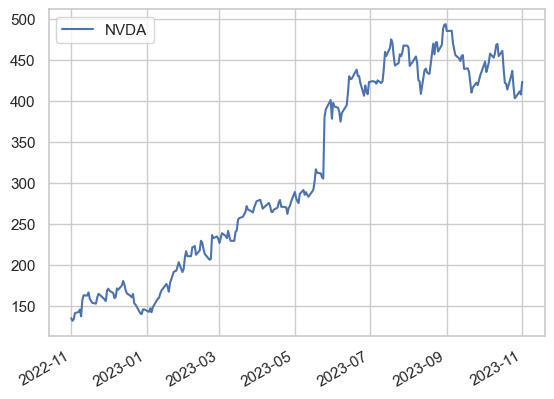

In [15]:
df.plot()

In [23]:
df = df.pct_change()

In [24]:
df

,NVDA
2022-10-17,NaN
2022-10-18,0.006645
2022-10-19,0.007019
2022-10-20,0.011866
2022-10-21,0.022306
...,...
2023-10-26,-0.034778
2023-10-27,0.004315
2023-10-30,0.016321
2023-10-31,-0.009256


In [26]:
#df.to_excel("NVDA_return.xlsx")

In [28]:
df = pd.read_excel("NVDA_return.xlsx")

In [31]:
df["Historical"] = df["NVDA"].rolling(10).std()*np.sqrt(252)

In [32]:
df

,Unnamed: 0,NVDA,Implied,Historical
0,2022-10-18,0.006645,0.0000,NaN
1,2022-10-19,0.007019,0.0000,NaN
2,2022-10-20,0.011866,0.0000,NaN
3,2022-10-21,0.022306,0.0000,NaN
4,2022-10-24,0.010669,0.0000,NaN
...,...,...,...,...
257,2023-10-26,-0.034778,0.4824,0.470050
258,2023-10-27,0.004315,0.4669,0.468425
259,2023-10-30,0.016321,0.4514,0.472117
260,2023-10-31,-0.009256,0.4409,0.427618


In [35]:
train = df[["NVDA", "Implied", "Historical"]].loc[10:251]
train

,NVDA,Implied,Historical
10,0.003408,0.62800,0.418753
11,-0.023924,0.63800,0.457631
12,0.015281,0.62680,0.458412
13,0.054765,0.61720,0.508970
14,0.010243,0.70420,0.509035
...,...,...,...
247,0.002970,0.34980,0.273657
248,-0.031612,0.38030,0.340191
249,0.013946,0.39325,0.316498
250,-0.046795,0.40620,0.375993


In [36]:
test = df["Historical"].tail(10)
test

252    0.408560
253    0.375688
254    0.446310
255    0.451381
256    0.463016
257    0.470050
258    0.468425
259    0.472117
260    0.427618
261    0.439365
Name: Historical, dtype: float64

In [118]:
garch = arch.arch_model(train["NVDA"], vol="GARCH", dist="t")

In [119]:
garch_res = garch.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 5491.105817780254
Iteration:      2,   Func. Count:     23,   Neg. LLF: 7880.3089803727835
Iteration:      3,   Func. Count:     31,   Neg. LLF: 4917.388556732898
Iteration:      4,   Func. Count:     47,   Neg. LLF: 1237.6899097913677
Iteration:      5,   Func. Count:     61,   Neg. LLF: 7248.990556175308
Iteration:      6,   Func. Count:     77,   Neg. LLF: 1547.8924584809517
Iteration:      7,   Func. Count:     86,   Neg. LLF: 1095.477594378334
Iteration:      8,   Func. Count:     96,   Neg. LLF: 690.7766830112491
Iteration:      9,   Func. Count:    102,   Neg. LLF: -120.93349876071409
Iteration:     10,   Func. Count:    108,   Neg. LLF: 1480.7280734823705
Iteration:     11,   Func. Count:    118,   Neg. LLF: 11783.47799000888
Iteration:     12,   Func. Count:    134,   Neg. LLF: 72303.01039906606
Iteration:     13,   Func. Count:    150,   Neg. LLF: 727.8077269092946
Iteration:     14,   Func. Count:    156,   Neg. LLF: 698.

In [120]:
garch_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                         NVDA   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                479.419
Distribution:      Standardized Student's t   AIC:                          -948.839
Method:                  Maximum Likelihood   BIC:                          -931.394
                                              No. Observations:                  242
Date:                      Wed, Nov 22 2023   Df Residuals:                      241
Time:                              23:11:10   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         3.5955e-03  1.817e-03      1.978  4.788e-02 [3.354e-05,7.157e-03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      2.4904e-03  2.525e-03      0.986      0.324 [-2.459e-03,7.440e-03]
alpha[1]       0.5913      1.468      0.403      0.687      [ -2.287,  3.469]
beta[1]        0.0403      0.424  9.488e-02      0.924      [ -0.791,  0.872]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             3.1531      0.344      9.153  5.540e-20 [  2.478,  3.828]
========================================================================

Covariance estimator: robust
"""

In [174]:
egarch = arch.arch_model(train["NVDA"], vol="EGARCH", p=1, o=1, q=1, dist="t")


In [175]:
egarch_res = egarch.fit()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 4319.650105016453
Iteration:      2,   Func. Count:     25,   Neg. LLF: 1399.4634170847498
Iteration:      3,   Func. Count:     35,   Neg. LLF: 587.3826558775826
Iteration:      4,   Func. Count:     44,   Neg. LLF: 105.21967730852816
Iteration:      5,   Func. Count:     53,   Neg. LLF: -502.4992241549155
Iteration:      6,   Func. Count:     60,   Neg. LLF: -503.81006178428566
Iteration:      7,   Func. Count:     67,   Neg. LLF: 546.9256689793583
Iteration:      8,   Func. Count:     76,   Neg. LLF: -495.07340495894346
Iteration:      9,   Func. Count:     87,   Neg. LLF: 229.25919564047837
Iteration:     10,   Func. Count:     95,   Neg. LLF: -474.62188201480944
Iteration:     11,   Func. Count:    103,   Neg. LLF: -496.5809900793388
Iteration:     12,   Func. Count:    111,   Neg. LLF: 1606.2104076471335
Iteration:     13,   Func. Count:    119,   Neg. LLF: -435.199285481125
Iteration:     14,   Func. Count:    127,   Neg. LLF

In [176]:
egarch_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - EGARCH Model Results                        
====================================================================================
Dep. Variable:                         NVDA   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:                510.330
Distribution:      Standardized Student's t   AIC:                          -1008.66
Method:                  Maximum Likelihood   BIC:                          -987.727
                                              No. Observations:                  242
Date:                      Wed, Nov 22 2023   Df Residuals:                      241
Time:                              23:17:46   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.6694e-03  1.523e-03      1.096      0.273 [-1.316e-03,4.655e-03]
                                Volatility Model                               
===============================================================================
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
omega          -0.0563  6.097e-05   -922.778      0.000 [-5.638e-02,-5.614e-02]
alpha[1]       -0.0906  4.103e-03    -22.095 3.495e-108 [-9.869e-02,-8.261e-02]
gamma[1]   -4.8850e-03  1.559e-03     -3.133  1.731e-03 [-7.941e-03,-1.829e-03]
beta[1]         0.9926  4.296e-07  2.310e+06      0.000       [  0.993,  0.993]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             6.5703      0.550     11.955  6.134e-33 [  5.493,  7.648]
========================================================================

Covariance estimator: robust
"""

In [177]:
gjr = arch.arch_model(train["NVDA"], vol="GARCH", p=1, o=1, q=1, dist="t")

In [178]:
gjr_res = gjr.fit()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 9962.598758459264
Iteration:      2,   Func. Count:     25,   Neg. LLF: -220.991800907251
Iteration:      3,   Func. Count:     33,   Neg. LLF: -362.64260086063973
Iteration:      4,   Func. Count:     41,   Neg. LLF: 496.34187830528543
Iteration:      5,   Func. Count:     49,   Neg. LLF: -497.96194344008745
Iteration:      6,   Func. Count:     57,   Neg. LLF: -202.95441496117442
Iteration:      7,   Func. Count:     65,   Neg. LLF: -481.8458364606745
Iteration:      8,   Func. Count:     73,   Neg. LLF: 195.0303458855021
Iteration:      9,   Func. Count:     81,   Neg. LLF: -499.38840048816917
Iteration:     10,   Func. Count:     89,   Neg. LLF: 70873.35825868466
Iteration:     11,   Func. Count:     99,   Neg. LLF: -164.13356688969796
Iteration:     12,   Func. Count:    110,   Neg. LLF: 1080.4992455295098
Iteration:     13,   Func. Count:    123,   Neg. LLF: 183.90425352092433
Iteration:     14,   Func. Count:    134,   Neg. L

In [179]:
gjr_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - GJR-GARCH Model Results                       
====================================================================================
Dep. Variable:                         NVDA   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                506.478
Distribution:      Standardized Student's t   AIC:                          -1000.96
Method:                  Maximum Likelihood   BIC:                          -980.022
                                              No. Observations:                  242
Date:                      Wed, Nov 22 2023   Df Residuals:                      241
Time:                              23:18:01   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         2.3409e-03  1.772e-03      1.321      0.186 [-1.131e-03,5.813e-03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.1059e-06  8.663e-08     47.396      0.000  [3.936e-06,4.276e-06]
alpha[1]   1.7351e-03  4.124e-03      0.421      0.674 [-6.347e-03,9.817e-03]
gamma[1]       0.0306  1.624e-02      1.885  5.949e-02 [-1.225e-03,6.242e-02]
beta[1]        0.9796  5.502e-03    178.035      0.000      [  0.969,  0.990]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.8352      1.622      2.982  2.867e-03 [  1.657,  8.014]
========================================================================

Covariance estimator: robust
"""

In [155]:
figarch = arch.arch_model(train["NVDA"], vol="FIGARCH", dist="t")

In [156]:
figarch_res = figarch.fit()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 6268.99225428671
Iteration:      2,   Func. Count:     25,   Neg. LLF: -286.90361320099004
Iteration:      3,   Func. Count:     33,   Neg. LLF: 664.9130997029858
Iteration:      4,   Func. Count:     43,   Neg. LLF: 402.7997551559711
Iteration:      5,   Func. Count:     51,   Neg. LLF: -492.53653181477307
Iteration:      6,   Func. Count:     59,   Neg. LLF: 2943.2011995940193
Iteration:      7,   Func. Count:     67,   Neg. LLF: 6791.934355971145
Iteration:      8,   Func. Count:     75,   Neg. LLF: -502.068051891701
Iteration:      9,   Func. Count:     83,   Neg. LLF: -497.033108074796
Iteration:     10,   Func. Count:     91,   Neg. LLF: -499.55079507708206
Iteration:     11,   Func. Count:     99,   Neg. LLF: -503.30504869895543
Iteration:     12,   Func. Count:    107,   Neg. LLF: -503.6011473762058
Iteration:     13,   Func. Count:    115,   Neg. LLF: -503.8491259885984
Iteration:     14,   Func. Count:    122,   Neg. LLF: 

In [157]:
figarch_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Constant Mean - FIGARCH Model Results                        
====================================================================================
Dep. Variable:                         NVDA   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                          FIGARCH   Log-Likelihood:                503.944
Distribution:      Standardized Student's t   AIC:                          -995.888
Method:                  Maximum Likelihood   BIC:                          -974.955
                                              No. Observations:                  242
Date:                      Wed, Nov 22 2023   Df Residuals:                      241
Time:                              23:15:43   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         2.6025e-03  1.768e-03      1.472      0.141 [-8.624e-04,6.068e-03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      8.7528e-05  1.445e-04      0.606      0.545 [-1.958e-04,3.708e-04]
phi            0.3669  7.084e-02      5.178  2.239e-07      [  0.228,  0.506]
d              0.1739      0.108      1.615      0.106   [-3.715e-02,  0.385]
beta           0.5404      0.111      4.855  1.204e-06      [  0.322,  0.759]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.2906      1.320      3.251  1.151e-03 [  1.704,  6.877]
========================================================================

Covariance estimator: robust
"""

In [158]:
garch_pred = garch_res.forecast(horizon=10).variance.dropna()

In [159]:
garch_pred

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10
251,0.003761,0.004866,0.005563,0.006004,0.006282,0.006458,0.006569,0.006639,0.006683,0.006711


In [160]:
egarch_pred = egarch_res.forecast(horizon=1).variance.dropna()

In [161]:
egarch_pred

,h.1
251,0.002017


In [162]:
gjr_pred = gjr_res.forecast(horizon=10).variance.dropna()

In [163]:
gjr_pred

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10
251,0.00196,0.00171,0.001555,0.001459,0.0014,0.001364,0.001341,0.001327,0.001318,0.001313


In [164]:
figarch_pred = figarch_res.forecast(horizon=10).variance.dropna()

In [165]:
figarch_pred

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10
251,0.00073,0.000767,0.000798,0.000811,0.000815,0.000817,0.000817,0.000817,0.000817,0.000817


(0.0, 1.5)

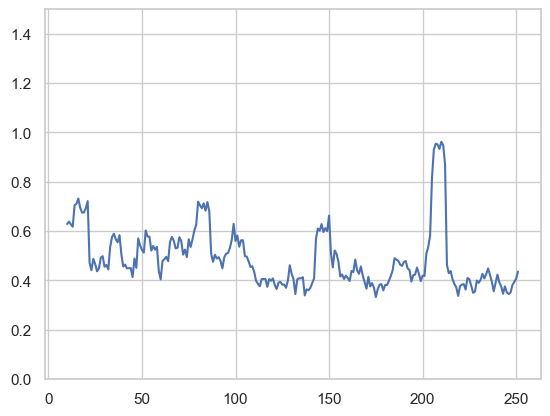

In [166]:
train["Implied"].plot()
plt.ylim([0, 1.5])

(0.0, 1.5)

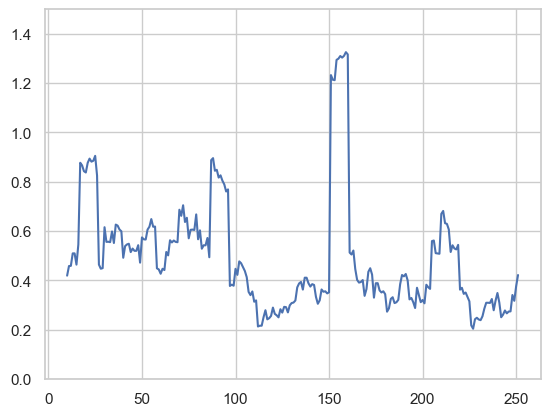

In [180]:
train["Historical"].plot()
plt.ylim([0, 1.5])

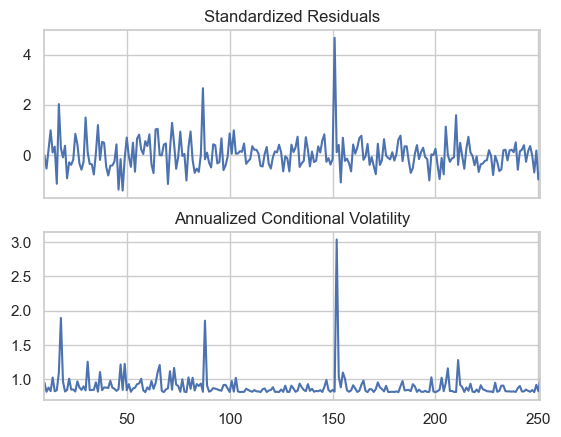

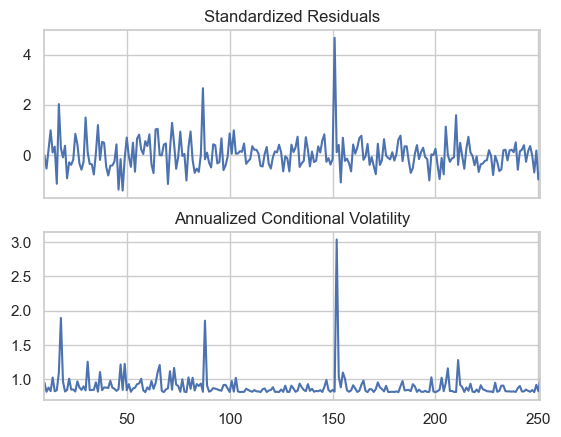

In [181]:
garch_res.plot(annualize="D")

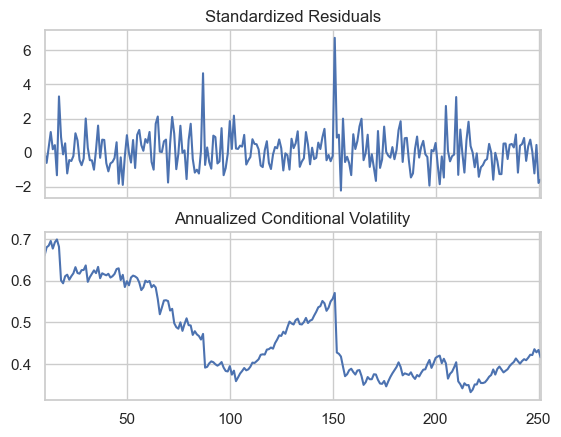

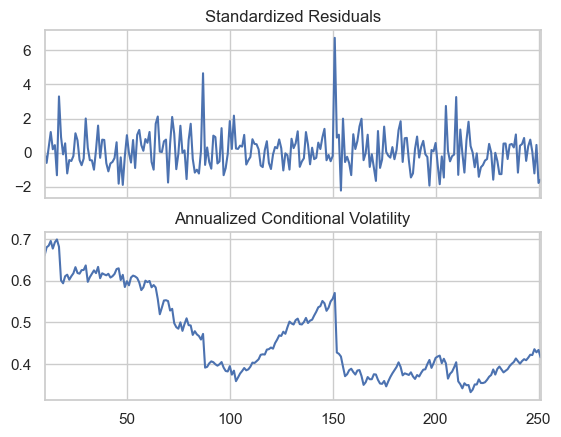

In [182]:
egarch_res.plot(annualize="D")

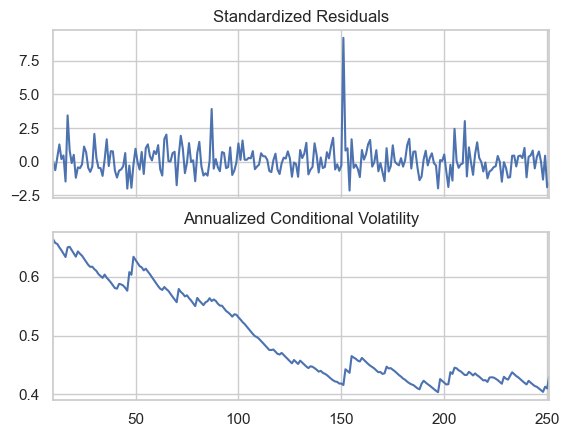

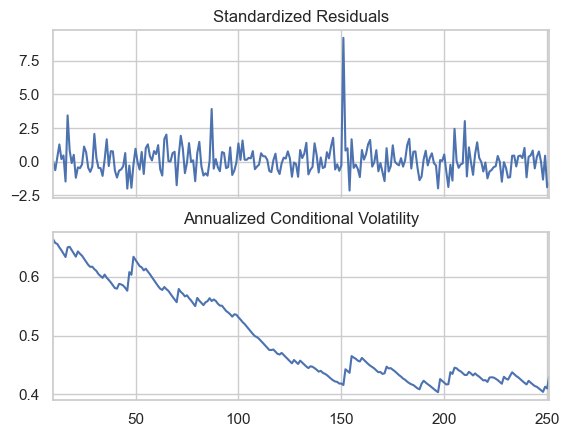

In [183]:
gjr_res.plot(annualize="D")

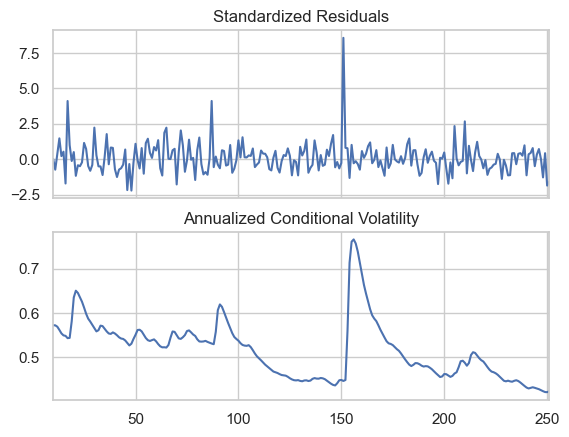

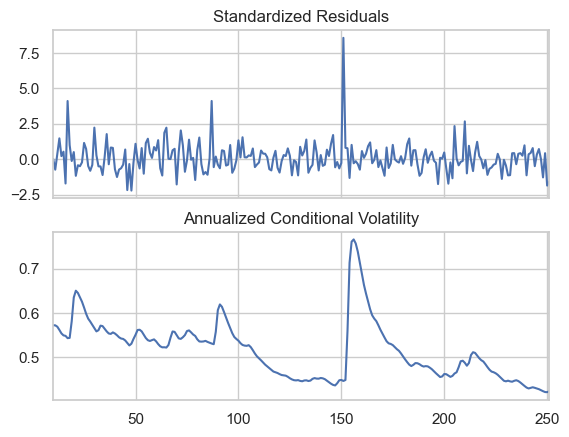

In [184]:
figarch_res.plot(annualize="D")

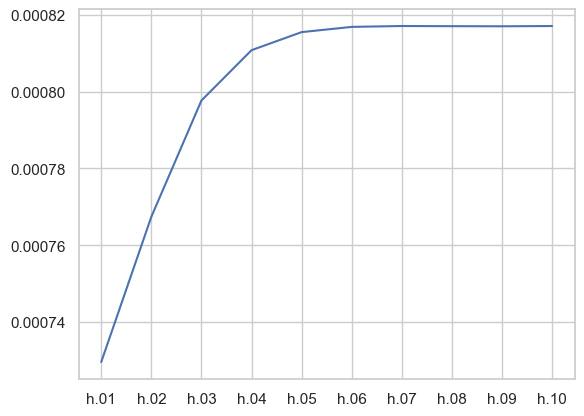

In [185]:
plt.plot(figarch_pred.T)

<Axes: >

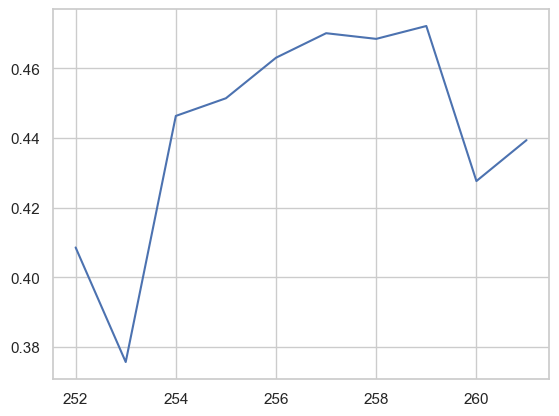

In [186]:
df["Historical"].tail(10).plot()

<Axes: >

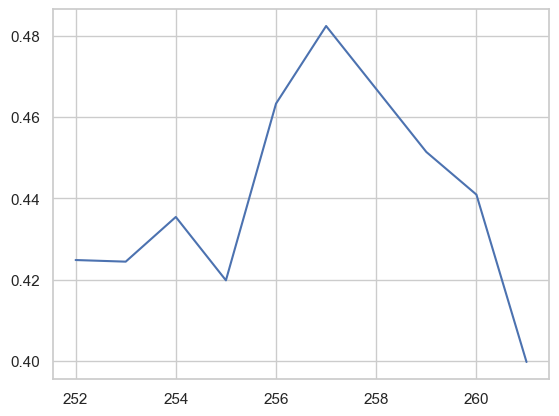

In [187]:
df["Implied"].tail(10).plot()

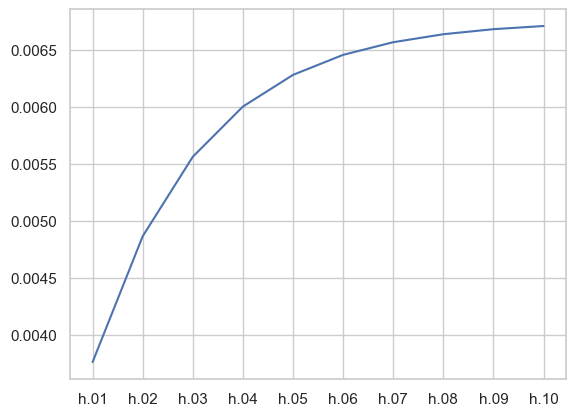

In [188]:
plt.plot(garch_pred.T)

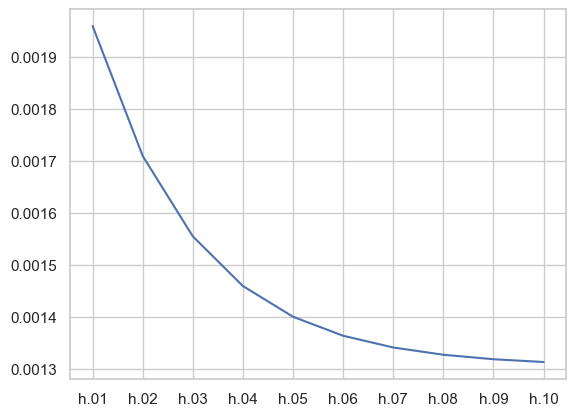

In [189]:
plt.plot(gjr_pred.T)